# Zillow

## Exploratory Analysis of Zillow Data

In [1]:
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:.2f}'.format

# Split 
from sklearn.model_selection import train_test_split

# Scale
from sklearn.preprocessing import MinMaxScaler

# Stats
import scipy.stats as stats

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#My Files
import env
from wrangle_zillow import *

Can leave unscaled for exploration, but scale before modeling!!


In [2]:
# aquire zillow data using function from wrangle_zillow
df = wrangle_zillow()
df.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,...,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,bath_bed_ratio
0,3.50,4,3100,orange,33634931,-117869207,4506,53571.00,1286,96978,...,2016,537569,11013,0.03,2017-01-01,0,1,0,19,0.88
1,1.00,2,1465,ventura,34449266,-119281531,12647,13091.00,2061,97099,...,2016,376000,5672,0.06,2017-01-01,0,0,1,50,0.50
2,2.00,3,1243,orange,33886168,-117823170,8432,21412.00,1286,97078,...,2016,479489,6488,0.01,2017-01-01,0,1,0,55,0.67
3,3.00,4,2376,los_angeles,34245180,-118240722,13038,396551.00,3101,96330,...,2016,36225,1777,-0.10,2017-01-01,1,0,0,47,0.75
6,3.00,4,2962,los_angeles,34145202,-118179824,63000,47019.00,3101,96293,...,2016,496619,9516,-0.00,2017-01-01,1,0,0,67,0.75


In [3]:
df.shape


(51945, 24)

In [4]:
# split data using function from
train, validate, test = split_data(df)

In [5]:
# scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [6]:
# train_scaled.head()

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

#### Notes: 

target = logerror

log_error = difference of log(Zestimate) and log(SalePrice)

Q: Why did Zillow pick the log error instead of an absolute error metric such as RMSE?

Home sale prices have a right skewed distribution and are also strongly heteroscedastic, so we need to use a relative error metric instead of an absolute metric to ensure valuation models are not biased towards expensive homes. A relative error metric like the percentage error or log ratio error avoids these problems. While we report Zestimate errors in terms of percentages on Zillow.com because we believe that to be a more intuitive metric for consumers, we do not advocate using percentage error to evaluate models in Zillow Prize, as it may lead to biased models The log error is free of this bias problem and when using the natural logarithm, errors close to 1 approximate percentage errors quite closely. See this paper for more on relative errors and why log error should be used instead of percentage error.

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2635088

#### Questions: 

1. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
2. 
3. 
4. 
5. 

2. Answer those questions through a mix of statistical tests and visualizations.

Question 1: 

Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Orange county has a greater log error than L.A. and Ventura counties; Ventura having the lowest log error. The mean log error is 0.02. L.A. and Ventura are below the average and Orange County is above the average log error. They are all very similar however. 

In [7]:
train.describe()

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,logerror,los_angeles,orange,ventura,age,bath_bed_ratio
count,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00,29089.00
mean,2.28,3.30,1899.37,34024104.39,-118193863.72,11306.04,33312.43,1.90,1963.21,186578.14,493449.33,306871.19,6028.09,0.02,0.65,0.27,0.08,53.79,0.70
std,0.98,0.93,938.98,274310.86,356191.60,88440.99,49554.57,3.14,23.02,196723.79,502157.07,357883.45,5789.82,0.17,0.48,0.44,0.28,23.02,0.24
min,1.00,1.00,300.00,33340620.00,-119475265.00,236.00,3491.00,0.00,1880.00,148.00,3254.00,161.00,49.00,-4.66,0.00,0.00,0.00,1.00,0.20
25%,2.00,3.00,1263.00,33827385.00,-118399974.00,5595.00,12447.00,0.00,1950.00,76088.00,190372.00,74077.00,2610.00,-0.02,0.00,0.00,0.00,38.00,0.50
50%,2.00,3.00,1650.00,34025724.00,-118153327.00,6795.00,24435.00,0.00,1960.00,130000.00,369000.00,214625.00,4594.00,0.01,1.00,0.00,0.00,57.00,0.67
75%,3.00,4.00,2290.00,34189058.00,-117930191.00,8720.00,40227.00,5.00,1979.00,223152.00,609149.00,402000.00,7272.00,0.04,1.00,1.00,0.00,67.00,0.80
max,10.00,12.00,11020.00,34818767.00,-117554636.00,6971010.00,396556.00,14.00,2016.00,3316500.00,4993132.00,4847224.00,59247.00,3.39,1.00,1.00,1.00,137.00,7.50


In [26]:
train.counties


61675    los_angeles
7581     los_angeles
48630    los_angeles
66151        ventura
38789         orange
            ...     
13961    los_angeles
38593    los_angeles
73204    los_angeles
32397         orange
31495    los_angeles
Name: counties, Length: 29089, dtype: object

In [8]:
train.shape


(29089, 24)

In [9]:
train.logerror.describe()

count   29089.00
mean        0.02
std         0.17
min        -4.66
25%        -0.02
50%         0.01
75%         0.04
max         3.39
Name: logerror, dtype: float64

In [10]:
train.columns

Index(['bathrooms', 'bedrooms', 'area', 'counties', 'latitude', 'longitude',
       'lot_area', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt',
       'yearbuilt', 'structuretaxvalue', 'taxvalue', 'assessmentyear',
       'landtaxvalue', 'taxamount', 'logerror', 'transactiondate',
       'los_angeles', 'orange', 'ventura', 'age', 'bath_bed_ratio'],
      dtype='object')

In [11]:
train.counties.head()

61675    los_angeles
7581     los_angeles
48630    los_angeles
66151        ventura
38789         orange
Name: counties, dtype: object

In [12]:
train.logerror.head()

61675   0.01
7581    0.42
48630   0.04
66151   0.02
38789   0.01
Name: logerror, dtype: float64

<AxesSubplot:ylabel='Frequency'>

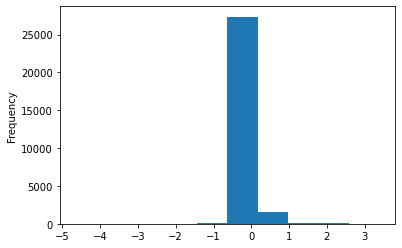

In [13]:
train.logerror.plot.hist()

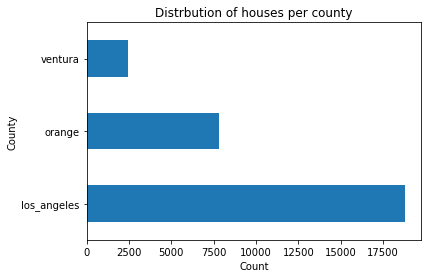

In [14]:
train.counties.value_counts().plot.barh()
plt.title('Distrbution of houses per county')
plt.ylabel('County')
plt.xlabel('Count')
plt.show()

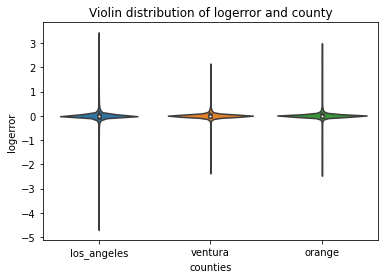

In [15]:
sns.violinplot(data=train, y='logerror', x='counties')
plt.title('Violin distribution of logerror and county')
plt.show()

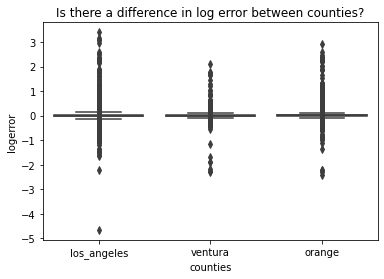

In [16]:
sns.boxplot(data=train, y='logerror', x='counties')
plt.title("Is there a difference in log error between counties?")
plt.show()

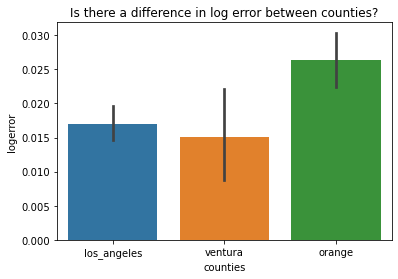

In [17]:
sns.barplot(data=train, y='logerror', x='counties')
plt.title("Is there a difference in log error between counties?")
plt.show()


In [19]:
train.columns


Index(['bathrooms', 'bedrooms', 'area', 'counties', 'latitude', 'longitude',
       'lot_area', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt',
       'yearbuilt', 'structuretaxvalue', 'taxvalue', 'assessmentyear',
       'landtaxvalue', 'taxamount', 'logerror', 'transactiondate',
       'los_angeles', 'orange', 'ventura', 'age', 'bath_bed_ratio'],
      dtype='object')

Levene's Test: test for equal variance

Null Hypothesis: there is no difference in log errors variance between the three samples
Alternaive Hypothesis: there is a difference in log errors variance between the three samples

In [28]:
stats.levene(
    df[df.counties == 'los_angeles'].logerror,
    df[df.counties == 'orange'].logerror,
    df[df.counties == 'ventura'].logerror,
)

LeveneResult(statistic=29.37455633525709, pvalue=1.7782850348343056e-13)

In [27]:
df[df.counties == 'los_angeles'].logerror

3       -0.10
6       -0.00
7        0.10
8       -0.04
10       0.01
         ... 
77374    0.00
77376    0.02
77378    0.04
77379    0.01
77380   -0.20
Name: logerror, Length: 33581, dtype: float64

Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.